In [1]:
import torch
from torch.nn import NLLLoss
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn

%matplotlib inline
import pylab as pl
from IPython import display
import time
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import sys
sys.path.append('../')
from helpful_files.networks import PROTO, avgpool, covapool, pL, pCL, fsL, fsCL, fbpredict
from helpful_files.testing import *

In [2]:
# Set Important Values

# General settings
datapath = '/data/dww78/mini_inat_shrunk/'                      # The location of your train, test, repr, and query folders. Make sure it ends in '/'!
model = '../orig-proto/orig-proto-Train-000.pth'               # What model do you wish to evaluate, and where is it saved?
gpu = 2                             # What gpu do you wish to run on?
workers = 1                         # Number of cpu worker processes to use for data loading
verbosity = 10                      # How many categories in between status updates 
ensemble = 4                        # How many models to evaluate in parallel
k = 5                               # Evaluate top-k accuracy. Typically 1 or 5. 
torch.cuda.set_device(gpu) 
cudnn.benchmark = True

# Model characteristics
covariance_pooling = False           # Did your model use covariance pooling?
localizing = False                   # Did your model use localization?
fewshot_local = False                # If you used localization: few-shot, or parametric? Few-shot if True, param if False
network_width = 64                  # Number of channels at every layer of the network

# Batch construction
bsize = 64                          # Batch size
boxes_available = 10                # Percentage of images with bounding boxes available (few-shot localization models only)
include_masks = (localizing         # Include or ignore the bounding box annotations?
                 and fewshot_local)
n_trials = (10                      # Number of trials (few-shot localization models only)
            if include_masks else 1)


# Calculate embedding size based on model setup
d = (network_width if not 
     covariance_pooling else
     network_width**2)
if localizing and not covariance_pooling:
    d = network_width*2
assert n_trials == 1 or include_masks, ("Repeated trials will yield repeated identical results under this configuration."+
                                        "Please set ntrials to 1 or use a few-shot localizer.")

In [3]:
# Load Testing Data

d_boxes = torch.load(datapath + 'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

repr_dataset = datasets.ImageFolder(
    datapath+'repr', 
    loader = lambda x: load_transform(x, d_boxes, transform, include_masks))
query_dataset = datasets.ImageFolder(
    datapath+'query',
    loader = lambda x: load_transform(x, d_boxes, transform, include_masks))
repr_loader = torch.utils.data.DataLoader(
    repr_dataset, 
    batch_sampler = OrderedSampler(repr_dataset, bsize),
    num_workers = workers,
    pin_memory = True)
query_loader = torch.utils.data.DataLoader(
    query_dataset,
    batch_sampler = OrderedSampler(query_dataset, bsize),
    num_workers = workers,
    pin_memory = True)
way = len(repr_dataset.classes)

# Determine number of images with bounding boxes per-class
catsizes = torch.LongTensor(np.array([t[1] for t in repr_dataset.imgs])).bincount().float()
ngiv = (catsizes*boxes_available//100)
for i in range(ngiv.size(0)):
    if ngiv[i] == 0:
        ngiv[i] = 1
ngiv = ngiv.long().tolist()

print('Data loaded!')

Data loaded!


In [4]:
# Make Models
    
models = [PROTO(network_width).cuda() for i in range(ensemble)]
expander = avgpool()
if localizing:
    if fewshot_local:
        expander = fsCL if covariance_pooling else fsL
    else:
        expander = pCL() if covariance_pooling else pL()
elif covariance_pooling:
    expander = covapool
expanders = [expander for _ in range(ensemble)]

# Load saved parameters
model_state = torch.load(model)
for i in range(ensemble):
    models[i].load_state_dict(model_state[i])
    models[i].eval()
    # Zero out the bias on the final layer, since it doesn't do anything
    models[i].process[-1].layers[-1].bias.data.zero_()

# Load additional parameters for parametric localizer models
if localizing and not fewshot_local:
    fbcentroids = torch.load(model[:model.rfind('.')]+'_localizers'+model[model.rfind('.'):])
    for i in range(ensemble):
        expanders[i].centroids.data = fbcentroids[i]
        expanders[i].cuda()

print("Ready to go!")

Ready to go!


In [5]:
#                                                    EVALUATE

In [6]:

# You don't want to append your tensor to total _accum 
# until after you've completed the category, so that should
# happen in the upper if then block and you should be concatenating
# to running in the lower for loop
# total _accum list should have 227 entries




# b is actually a different number for every class 
# esize = 4; total accum should be 4 x 227 x b x d
# 227 classes, for each categories size of embeddings is of size b x d
# list of length 4 containing lists of length 227, each element of list will be a b x d tensor

# total accum: [[[bxd],..,[b227xd]], [[*bxd],...,[*b227xd]], [[**bxd],...[**b227xd]], [[***bxd],...,[***b227xd]]]
# [4,227,b,d]


In [7]:
def accumulate(models, loader, expanders, bcentroids, way, d):
    esize = len(models)
    total_accum = [[],[],[],[]]
    catindex = 0
    lastcat = -1
    count = 0
    running = [torch.zeros(0, d)]*4
    counts = [0]*way
    progress = torch.zeros(1, way)
    for i, ((inp,_), cat) in enumerate(loader):
        catindex = cat[0]

        # Moving to another category
        if catindex != lastcat: 
            if i != 0:
                for j in range(esize):
                    total_accum[j].append(running[j]) # Write the values
                counts[lastcat] = count
            lastcat = catindex # Record the current category
            count = 0
            running = [torch.zeros(0, d)]*4
            progress[0, lastcat] = 1
            # Plot progress
            display.clear_output(wait=True)
            pl.figure(figsize=(20,1))
            pl.imshow(progress.numpy(), cmap='Greys')
            pl.title("Accumulating category prototypes:")
            pl.xticks([])
            pl.yticks([])
            pl.show()
            sleep(.01)

        # Continue accumulating
        inp = inp.cuda()
        with torch.no_grad():
            for j in range(esize):
                out = models[j](inp) # b 64 10 10
                out = expanders[j](out, bcentroids[j], None) # b d
                running[j] = torch.cat((running[j], out.cpu()), 0)
        count += inp.size(0)
                                       
    # Record last category
    for j in range(esize):
        total_accum[j].append(running[j])
        counts[catindex] = count
#     print(len(total_accum))
#     print(len(total_accum[0]))
#     for i in total_accum[0]:
#         print(len(i))
    return total_accum, counts

In [8]:
# predict

# TODO: write predict functions using SVM (sci-kit), L2-norm nearest-neighbors, arg to predict fxn
# will be list of all tensors rather than centroids
# Overview:
# take data structure total_accum, get labels, and turn it into an numpy array to feed into an SVM

# convert total_accum into x_train, 4 different SVMs
# train an SVM on xtrain and make a prediction, return that one prediction
# xtrain: [sum(b)x64] - d is 64
# create the labels: (sum(b) x 1)
# first b entries in total accum come from category 0, next b from category 1....

def SVM_train(total_accum):
    #     total_accum = [227,b,d]
    #     X_train: [9187, d]
    #     Y_train: [9187x1]
    print("entering SVM train")
    X_train = np.concatenate(tuple([i for i in total_accum]))

    Y_train = []
    for i in range(len(total_accum)):
        b = len(total_accum[i]) 
        Y_train += [i]*b

    #Create a svm Classifier
#     clf = svm.LinearSVC() # Linear Kernel
    #Train the model using the training sets
#     clf.fit(X_train, Y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    clf = CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, class_weight= 'balanced'))
    clf.fit(X_train, Y_train)
    return clf


def predict(train_model, x_test):
#     x_test = [64, 4096]
    print("in predict")
    print(len(x_test))
    print(len(x_test[0]))
    #Predict the response for test dataset
#     print("entering predict")
    clf = train_model
#     y_pred = clf.predict(x_test)
#     y_proba = clf.predict_proba(x_test)

    y_proba = clf.predict_proba(x_test)
    best_k = np.argsort(y_proba, axis=1)[:,-k:]
#     print(y_proba.shape)
#    -------------- DAVIS's code
#     distmat = torch.sum((centroids-query)**2,-1).neg().view(-1, centroids.size(-2))
#     return F.log_softmax(distmat, dim=-1)
    return best_k


In [9]:
def score(k, total_accum, bcentroids, models, loader, expanders, way):
    esize = len(models)
    right = [0]*esize
    allright = [0]*esize
    perclassacc = np.array([[0.]*way for _ in range(esize)])
    catindex = 0
    lastcat = -1
    count = 0
    allcount = 0
    progress = torch.zeros(1, way)
    train_models = []
     
    for i in range(esize):
        train_models.append(SVM_train(total_accum[i]))
    
    for i, ((inp,_), cat) in enumerate(loader):
        catindex = cat[0]
        if catindex != lastcat: # We're about to move to another category
            # Write the values
            if i!= 0:
                allcount += count
                for j in range(esize):
                    allright[j] += right[j] 
                    perclassacc[j, lastcat] = right[j]/count
            lastcat = catindex # Record the current category
            count = 0 # Reset divisor
            right = [0]*esize # Reset accumulator
            progress[0, lastcat] = 1
            # Plot progress
            display.clear_output(wait=True)
            pl.figure(figsize=(20,1))
            pl.imshow(progress.numpy(), cmap='Greys')
            pl.title("Accumulating accuracy scores:")
            pl.xticks([])
            pl.yticks([])
            pl.show()
            sleep(.01)

        # Predict
        inp = inp.cuda()
        targ = cat.cuda()
        with torch.no_grad():
            for j in range(esize):
                out = models[j](inp)
                out = expanders[j](out, bcentroids[j], None)
                out = predict(train_models[j], out.cpu())
                pred = torch.tensor(out).cuda()
#                 [64,5]
#                 _, pred = out.topk(k, 1, True, True)
                pred = pred.t() 
#     {pred should be [k x 64]}
#                 expand = pred.eq(targ.view(1, -1).expand_as(pred))
#                 print(expand.shape)
#                 expand2 = pred.eq(targ.view(1, -1).expand_as(pred))[:k].view(-1)
#                 print(expand2.shape)
#                 expand3 = pred.eq(targ.view(1, -1).expand_as(pred))[:k].view(-1).sum(0, keepdim=True)
#                 print(expand2.shape)
                right[j] += pred.eq(targ.view(1, -1).expand_as(pred))[:k].view(-1).sum(0, keepdim=True).float().item()
#                 right[j] += pred.eq(targ.expand_as(pred))[:k].view(-1).sum(0, keepdim=True).float().item()
        count += inp.size(0)

    # Record last category
    allcount += count
    for j in range(esize):
        allright[j] += right[j]
        perclassacc[j, catindex] = right[j]/count

    # Final reporting / recording
    allacc = [r/allcount for r in allright]
    
    return allacc, np.mean(perclassacc, axis=0), np.mean(perclassacc, axis=1)


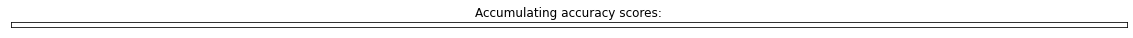

in predict
46
64
in predict
46
64
in predict
46
64
in predict
46
64
Accuracies and 95% confidence intervals
Mean accuracy: 		21.85 	+/- 0.92
Per-class accuracy: 	8 	+/- 0.60


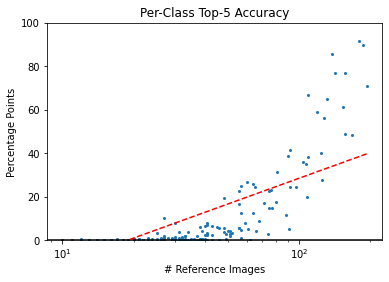

In [10]:
acclist = []
pcacclist = []
alldispacc = np.zeros(way)
for r in range(n_trials):
    # Accumulate foreground/background prototypes, if using
    fbcentroids = (accumulateFB(models, repr_loader, way, network_width, ngiv, bsize)
                   if include_masks else 
                   [None]*ensemble)
    # Accumulate category prototypes

    SVM_points, counts = accumulate(models, repr_loader, expanders, 
                                   fbcentroids, way, d)
    
    # Score the models
    allacc, dispacc, perclassacc = score(k, SVM_points, fbcentroids, models, 
                                         query_loader, expanders, way)
    # Record statistics
    acclist = acclist+allacc
    pcacclist = pcacclist+list(perclassacc)
    alldispacc += dispacc

# Aggregate collected statistics
accs = sum(acclist)/n_trials/ensemble
pcaccs = sum(pcacclist)/n_trials/ensemble
alldispacc = alldispacc/n_trials
confs = 1.96*np.sqrt(np.var(acclist)/n_trials/ensemble)
pcconfs = 1.96*np.sqrt(np.var(pcacclist)/n_trials/ensemble)

# Report
print("Accuracies and 95% confidence intervals")
print("Mean accuracy: \t\t%.2f \t+/- %.2f" % (accs*100, confs*100))
print("Per-class accuracy: \t%.f \t+/- %.2f" % (pcaccs*100, pcconfs*100))
logcounts = [np.log10(c) for c in counts]
pl.figure()
pl.axhline(0,color='k')
pl.scatter(counts, dispacc*100, s=4)
z = np.polyfit(logcounts, np.array(dispacc)*100, 1)
p = np.poly1d(z)
pl.plot([min(counts),max(counts)], [p(min(logcounts)),p(max(logcounts))], "r--")
pl.ylim([0,100])
pl.xlabel('# Reference Images')
pl.ylabel('Percentage Points')
pl.xscale('log')
pl.title('Per-Class Top-%d Accuracy' % k)
pl.show()

In [11]:
# Shut down the notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>